<a href="https://colab.research.google.com/github/Permanganant/AI-in-Medicine-I/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=78ff6d51dc75178d8de488ad91f7ba29d8a29f85c47e5cba2f1a609e32d2ad3c
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [ ]:
import medmnist

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO

In [ ]:
def train(model, loader, optimizer, convert_to_binary, epochs, device):
    model.to(device)

    if convert_to_binary:
        criterion_binary = nn.BCEWithLogitsLoss()
    else:
        criterion_multi = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        avg_loss = 0
        for inputs, targets in tqdm(loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            if convert_to_binary:
                targets = torch.any(targets, dim=1, keepdim=True).to(torch.float32)
                targets = torch.cat((1 - targets, targets), dim=1)
                loss = criterion_binary(outputs, targets)
            else:
                targets = targets.squeeze().long()
                loss = criterion_multi(outputs, targets)

            avg_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_loss /= len(loader)
        print('Epoch: {}\tLoss: {:.4f}'.format(epoch + 1, avg_loss))

    return model


In [ ]:
def test(model, data_loader, device, convert_to_binary):
    model.eval()
    model.to(device)

    y_true = torch.tensor([], dtype=torch.float32, device=device)
    y_score = torch.tensor([], device=device)

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            if convert_to_binary:
                targets = torch.any(targets, dim=1, keepdim=True).to(torch.float32)
                targets = torch.cat((1 - targets, targets), dim=1)

            outputs = outputs.softmax(dim=-1)

            if targets.size(1) == 1:
                targets = torch.cat((1 - targets, targets), dim=1)

            y_true = torch.cat((y_true, targets[:, 1].unsqueeze(1)), 0)
            y_score = torch.cat((y_score, outputs[:, 1].unsqueeze(1)), 0)

        y_preds = (y_score >= 0.5).to(torch.int)

        # TODO: Accuracy
        acc = torch.sum(y_preds == y_true).item() / len(y_true)

        print('acc: %.3f' % (acc))
        return y_preds.flatten(), y_true.flatten()


# Chest

In [ ]:
data_flag_chest = 'chestmnist'
download = True

lr = 0.001

info_chest = INFO[data_flag_chest]
task_chest = info_chest['task']
n_channels_chest = info_chest['n_channels']
n_classes_chest = 2
DataClass_chest = getattr(medmnist, info_chest['python_class'])

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the chest data
train_dataset_chest = DataClass_chest(split='train', transform=data_transform, download=download)
test_dataset_chest = DataClass_chest(split='test', transform=data_transform, download=download)

train_dataset_chest_full = DataClass_chest(split='train', transform=data_transform, download=download)
train_loader_chest_full = data.DataLoader(dataset=train_dataset_chest_full, batch_size=256, shuffle=True)

# Lets pretend we only have labels for 300 training examples
train_dataset_chest.imgs = train_dataset_chest.imgs[:300]
train_dataset_chest.labels = train_dataset_chest.labels[:300]

# encapsulate data into dataloader form
train_loader_chest = data.DataLoader(dataset=train_dataset_chest, batch_size=64, shuffle=True)
test_loader_chest = data.DataLoader(dataset=test_dataset_chest, batch_size=64, shuffle=False)

100%|██████████| 82802576/82802576 [00:05<00:00, 16342252.46it/s]


Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz


In [ ]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )

        self.fc = nn.Sequential(
            nn.Linear(128*4, num_classes)
        )

        self.extract_embeddings = False

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_chest = Net(in_channels=n_channels_chest, num_classes=2).to(device)

optimizer_chest = optim.SGD(model_chest.parameters(), lr=lr, momentum=0.9)

model_chest = train(model_chest, train_loader_chest, optimizer_chest, convert_to_binary=True, epochs=20, device=device)

100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


Epoch: 1	Loss: 0.7220


100%|██████████| 5/5 [00:00<00:00, 77.62it/s]


Epoch: 2	Loss: 0.6900


100%|██████████| 5/5 [00:00<00:00, 75.28it/s]


Epoch: 3	Loss: 0.6496


100%|██████████| 5/5 [00:00<00:00, 73.48it/s]


Epoch: 4	Loss: 0.6202


100%|██████████| 5/5 [00:00<00:00, 73.17it/s]


Epoch: 5	Loss: 0.5898


100%|██████████| 5/5 [00:00<00:00, 77.69it/s]


Epoch: 6	Loss: 0.5650


100%|██████████| 5/5 [00:00<00:00, 67.86it/s]


Epoch: 7	Loss: 0.5481


100%|██████████| 5/5 [00:00<00:00, 71.17it/s]


Epoch: 8	Loss: 0.5246


100%|██████████| 5/5 [00:00<00:00, 75.42it/s]


Epoch: 9	Loss: 0.5034


100%|██████████| 5/5 [00:00<00:00, 71.18it/s]


Epoch: 10	Loss: 0.4881


100%|██████████| 5/5 [00:00<00:00, 69.23it/s]


Epoch: 11	Loss: 0.4687


100%|██████████| 5/5 [00:00<00:00, 74.47it/s]


Epoch: 12	Loss: 0.4576


100%|██████████| 5/5 [00:00<00:00, 70.55it/s]


Epoch: 13	Loss: 0.4358


100%|██████████| 5/5 [00:00<00:00, 68.10it/s]


Epoch: 14	Loss: 0.4175


100%|██████████| 5/5 [00:00<00:00, 62.75it/s]


Epoch: 15	Loss: 0.4046


100%|██████████| 5/5 [00:00<00:00, 66.45it/s]


Epoch: 16	Loss: 0.3869


100%|██████████| 5/5 [00:00<00:00, 74.84it/s]


Epoch: 17	Loss: 0.3665


100%|██████████| 5/5 [00:00<00:00, 75.05it/s]


Epoch: 18	Loss: 0.3533


100%|██████████| 5/5 [00:00<00:00, 66.87it/s]


Epoch: 19	Loss: 0.3371


100%|██████████| 5/5 [00:00<00:00, 77.84it/s]

Epoch: 20	Loss: 0.3217


In [ ]:

y_preds, y_true = test(model_chest,test_loader_chest,device=device,convert_to_binary= True)
y_preds = y_preds.cpu().numpy()
y_true = y_true.cpu().numpy()
y_preds = np.array(y_preds)
y_true = np.array(y_true)
# Calculate positive rate
positive_rate = np.sum(y_true == 1)/len(y_true)
print("Positive rate: {:.4f}".format(positive_rate))


acc: 0.593
Positive rate: 0.4683


In [ ]:
# evaluation
print('==> Evaluating ...')
print('train')
test(model_chest, train_loader_chest, device, convert_to_binary=True)
print('test')
test(model_chest, test_loader_chest, device, convert_to_binary=True)

==> Evaluating ...
train
acc: 0.957
test
acc: 0.589


(tensor([0, 0, 0,  ..., 1, 0, 1], device='cuda:0', dtype=torch.int32),
 tensor([0., 0., 1.,  ..., 1., 1., 1.], device='cuda:0'))

## Latent Space

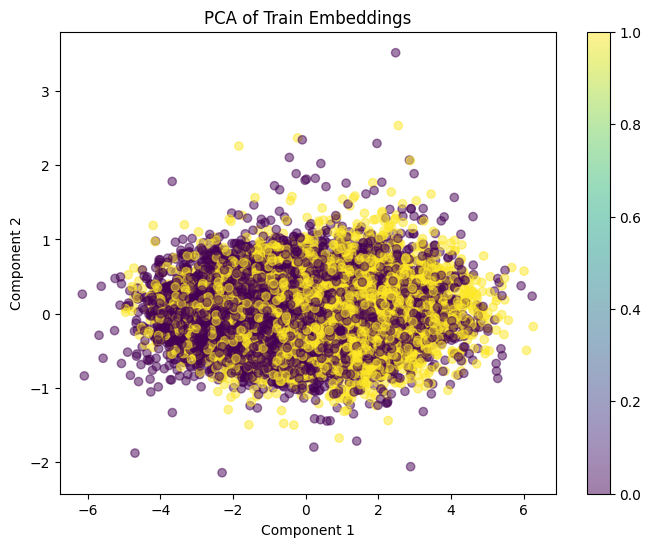

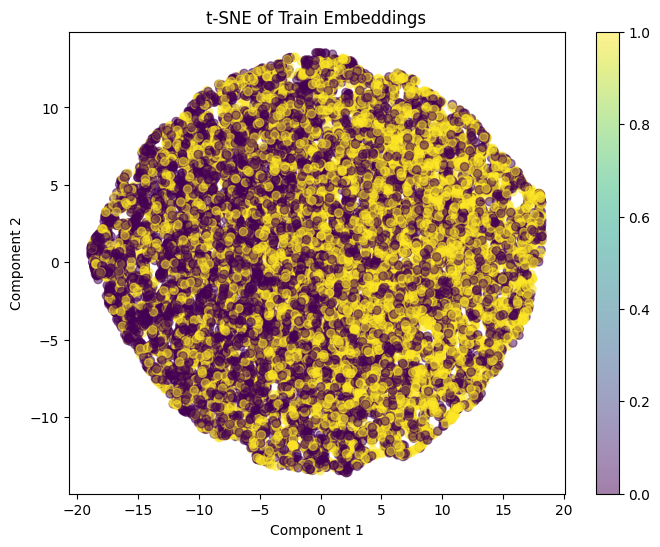

In [ ]:
# EXAMINE LATENT SPACE

# Function to extract embeddings - TODO: Adjust the Net class to extract embeddings
def extract_embeddings(dataloader, model):
    embeddings = []
    labels = []

    with torch.no_grad():
        for x, target in dataloader:
            x = x.to(device)
            target = target.to(device)

            model.extract_embeddings = True
            output = model(x)
            model.extract_embeddings = False

            embeddings.append(output)
            labels.append(target)

    return torch.cat(embeddings), torch.cat(labels)

# Function to plot
def plot_embeddings(embeddings, labels, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

test_embeddings, test_labels = extract_embeddings(test_loader_chest, model_chest)

# TODO: convert labels to binary
test_labels = torch.any(test_labels, dim=1, keepdim=True).to(torch.float32)


import numpy as np
import matplotlib.pyplot as plt

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TODO: Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(test_embeddings_flat)


# TODO: Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(test_embeddings_flat)

# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu(), 'PCA of Train Embeddings')

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu(), 't-SNE of Train Embeddings')


## Autoencoder

In [ ]:
!pip install torchmetrics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 9.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TODO: Define an autoencoder model that is compatable with the previous model. Use dropout with probability p
class Autoencoder(nn.Module):
    def __init__(self,p):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(p=0.5, inplace=False),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=0.5, inplace=False),
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=0.5, inplace=False),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(p=0.5, inplace=False),
            nn.Conv2d(128, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(1)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(p=0.5, inplace=False),
            nn.ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(p=0.5, inplace=False),
            nn.ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=0.5, inplace=False),
            nn.ConvTranspose2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(p=0.5, inplace=False),
            nn.ConvTranspose2d(128, 1, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), output_padding=(1, 1)),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x




# Initialize the model, criterion, and optimizer
model_ae = Autoencoder(p=0.5).to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.AdamW(model_ae.parameters(), lr=0.0001, weight_decay=0.01)

# Metrics
psnr_metric = PeakSignalNoiseRatio().to(device)
ssim_metric = StructuralSimilarityIndexMeasure().to(device)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model_ae.train()
    for x in train_loader_chest_full:
        inputs, _ = x
        inputs = inputs.to(device)

        # Forward pass
        outputs = model_ae(inputs)
        loss = criterion_ae(outputs, inputs)

        psnr_value = psnr_metric(outputs, inputs)
        ssim_value = ssim_metric(outputs, inputs)

        # Backward pass and optimization
        optimizer_ae.zero_grad()
        loss.backward()
        optimizer_ae.step()


    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, PSNR: {psnr_value.item():.4f}, SSIM: {ssim_value.item():.4f}')

    psnr_metric.reset()
    ssim_metric.reset()

# Test the autoencoder on the test set
model_ae.eval()
test_loss = 0.0
psnr_value_test = 0.0, 0.0
ssim_value_test = 0.0, 0.0
with torch.no_grad():
    for x in test_loader_chest:
        inputs, _ = x
        inputs = inputs.to(device)
        outputs = model_ae(inputs)

        loss = criterion_ae(outputs, inputs)
        psnr_value_test = psnr_metric(outputs, inputs)
        ssim_value_test = ssim_metric(outputs, inputs)

        test_loss += loss.item()

average_test_loss = test_loss / len(test_loader_chest.dataset)
average_psnr_test = psnr_metric.compute()
average_ssim_test = ssim_metric.compute()

print(f'Average Test Loss: {average_test_loss:.4f}, Average PSNR: {average_psnr_test:.4f}, Average SSIM: {average_ssim_test:.4f}')


Epoch [1/10], Loss: 0.2274, PSNR: 12.1766, SSIM: 0.0565
Epoch [2/10], Loss: 0.2086, PSNR: 12.5513, SSIM: 0.0838
Epoch [3/10], Loss: 0.2199, PSNR: 12.3221, SSIM: 0.0529
Epoch [4/10], Loss: 0.1865, PSNR: 13.0372, SSIM: 0.0796
Epoch [5/10], Loss: 0.1996, PSNR: 12.7067, SSIM: 0.0885
Epoch [6/10], Loss: 0.2022, PSNR: 12.6851, SSIM: 0.0856
Epoch [7/10], Loss: 0.1866, PSNR: 13.1037, SSIM: 0.0945
Epoch [8/10], Loss: 0.1987, PSNR: 12.8657, SSIM: 0.0940
Epoch [9/10], Loss: 0.1872, PSNR: 12.8791, SSIM: 0.0878
Epoch [10/10], Loss: 0.1852, PSNR: 13.1374, SSIM: 0.0823
Average Test Loss: 0.0027, Average PSNR: 13.5114, Average SSIM: 0.1467


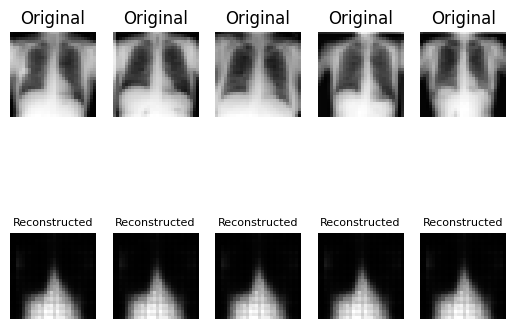

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
def plot_images(model, test_loader, device, num_images=5):
    model.eval()

    # Get a batch of test images
    with torch.no_grad():
        for data in test_loader:
            inputs, _ = data
            inputs = inputs.to(device)

            # Forward pass
            outputs = model(inputs)

            # Move data back to CPU for plotting
            inputs_cpu = inputs.cpu()
            outputs_cpu = outputs.cpu()

            # Plot the original and reconstructed images
            for i in range(num_images):
                plt.subplot(2, num_images, i + 1)
                plt.imshow(inputs_cpu[i].squeeze().numpy(), cmap='gray')
                plt.title('Original')
                plt.axis('off')

                plt.subplot(2, num_images, i + 1 + num_images)
                plt.imshow(outputs_cpu[i].squeeze().numpy(), cmap='gray')
                plt.title('Reconstructed', fontsize=8)
                plt.axis('off')

            plt.show()
            break

# Use the function to plot images
plot_images(model_ae, test_loader_chest, device)

### Transfer Learning

In [ ]:
# Create a new model with randomly initialized weights
model_transfer = Net(in_channels=n_channels_chest, num_classes=2).to(device)

# Load the state_dict from the Autoencoder model
autoencoder_state_dict = model_ae.state_dict()

# Transfer the weights to the corresponding layers in the Net model
model_transfer.layer1[0].weight.data.copy_ = autoencoder_state_dict['decoder.0.weight']
model_transfer.layer1[0].bias.data.copy_ = autoencoder_state_dict['decoder.0.bias']

model_transfer.layer2[0].weight.data.copy_ = autoencoder_state_dict['decoder.4.weight']
model_transfer.layer2[0].bias.data.copy_ = autoencoder_state_dict['decoder.4.bias']

model_transfer.layer3[0].weight.data.copy_ = autoencoder_state_dict['decoder.8.weight']
model_transfer.layer3[0].bias.data.copy_ = autoencoder_state_dict['decoder.8.bias']

model_transfer.layer4[0].weight.data.copy_ = autoencoder_state_dict['decoder.12.weight']
model_transfer.layer4[0].bias.data.copy_ = autoencoder_state_dict['decoder.12.bias']

# train
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=lr, momentum=0.9)

model_transfer = train(model_transfer, train_loader_chest, optimizer_transfer, convert_to_binary=True, epochs=20, device=device)

100%|██████████| 5/5 [00:00<00:00, 73.06it/s]


Epoch: 1	Loss: 0.7315


100%|██████████| 5/5 [00:00<00:00, 76.28it/s]


Epoch: 2	Loss: 0.6827


100%|██████████| 5/5 [00:00<00:00, 69.48it/s]


Epoch: 3	Loss: 0.6424


100%|██████████| 5/5 [00:00<00:00, 69.34it/s]


Epoch: 4	Loss: 0.6150


100%|██████████| 5/5 [00:00<00:00, 74.61it/s]


Epoch: 5	Loss: 0.5766


100%|██████████| 5/5 [00:00<00:00, 70.13it/s]


Epoch: 6	Loss: 0.5658


100%|██████████| 5/5 [00:00<00:00, 68.00it/s]


Epoch: 7	Loss: 0.5331


100%|██████████| 5/5 [00:00<00:00, 59.03it/s]


Epoch: 8	Loss: 0.5102


100%|██████████| 5/5 [00:00<00:00, 69.98it/s]


Epoch: 9	Loss: 0.4876


100%|██████████| 5/5 [00:00<00:00, 61.81it/s]


Epoch: 10	Loss: 0.4744


100%|██████████| 5/5 [00:00<00:00, 72.42it/s]


Epoch: 11	Loss: 0.4571


100%|██████████| 5/5 [00:00<00:00, 71.67it/s]


Epoch: 12	Loss: 0.4376


100%|██████████| 5/5 [00:00<00:00, 67.83it/s]


Epoch: 13	Loss: 0.4202


100%|██████████| 5/5 [00:00<00:00, 69.50it/s]


Epoch: 14	Loss: 0.4057


100%|██████████| 5/5 [00:00<00:00, 67.75it/s]


Epoch: 15	Loss: 0.3898


100%|██████████| 5/5 [00:00<00:00, 68.51it/s]


Epoch: 16	Loss: 0.3717


100%|██████████| 5/5 [00:00<00:00, 72.57it/s]


Epoch: 17	Loss: 0.3675


100%|██████████| 5/5 [00:00<00:00, 70.79it/s]


Epoch: 18	Loss: 0.3414


100%|██████████| 5/5 [00:00<00:00, 71.13it/s]


Epoch: 19	Loss: 0.3271


100%|██████████| 5/5 [00:00<00:00, 72.08it/s]

Epoch: 20	Loss: 0.3086


In [ ]:
print('==> Evaluating ...')
test(model_transfer, train_loader_chest, device, convert_to_binary=True)
test(model_transfer, test_loader_chest, device, convert_to_binary=True)

==> Evaluating ...
acc: 0.947
acc: 0.587


(tensor([0, 0, 0,  ..., 1, 0, 1], device='cuda:0', dtype=torch.int32),
 tensor([0., 0., 1.,  ..., 1., 1., 1.], device='cuda:0'))

# Pneumonia

In [ ]:
data_flag_pneumonia = 'pneumoniamnist'
info_pneumonia = INFO[data_flag_pneumonia]
task_pneumonia = info_pneumonia['task']
n_channels_pneumonia = info_pneumonia['n_channels']
n_classes_pneumonia = len(info_pneumonia['label'])
DataClass_pneumonia = getattr(medmnist, info_pneumonia['python_class'])

# load the pneumonia data
train_dataset_pneumonia = DataClass_pneumonia(split='train', transform=data_transform, download=download)
test_dataset_pneumonia = DataClass_pneumonia(split='test', transform=data_transform, download=download)

pil_dataset_pneumonia = DataClass_pneumonia(split='train', download=download)

# encapsulate data into dataloader form
train_loader_pneumonia = data.DataLoader(dataset=train_dataset_pneumonia, batch_size=64, shuffle=True)
test_loader_pneumonia = data.DataLoader(dataset=test_dataset_pneumonia, batch_size=64, shuffle=False)

100%|██████████| 4170669/4170669 [00:01<00:00, 3115455.23it/s]


Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


In [ ]:
model_pneumonia = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)

optimizer_pneumonia = optim.SGD(model_pneumonia.parameters(), lr=lr, momentum=0.9)

In [ ]:
# train
model_pneumonia = train(model_pneumonia, train_loader_pneumonia, optimizer_pneumonia, convert_to_binary=False, epochs=10, device=device)

100%|██████████| 74/74 [00:01<00:00, 60.09it/s]


Epoch: 1	Loss: 0.0165


100%|██████████| 74/74 [00:01<00:00, 49.19it/s]


Epoch: 2	Loss: 0.0136


100%|██████████| 74/74 [00:01<00:00, 47.10it/s]


Epoch: 3	Loss: 0.0125


100%|██████████| 74/74 [00:01<00:00, 63.37it/s]


Epoch: 4	Loss: 0.0103


100%|██████████| 74/74 [00:01<00:00, 68.32it/s]


Epoch: 5	Loss: 0.0101


100%|██████████| 74/74 [00:01<00:00, 66.53it/s]


Epoch: 6	Loss: 0.0081


100%|██████████| 74/74 [00:01<00:00, 67.43it/s]


Epoch: 7	Loss: 0.0073


100%|██████████| 74/74 [00:01<00:00, 68.07it/s]


Epoch: 8	Loss: 0.0059


100%|██████████| 74/74 [00:01<00:00, 68.96it/s]


Epoch: 9	Loss: 0.0059


100%|██████████| 74/74 [00:01<00:00, 69.45it/s]

Epoch: 10	Loss: 0.0050


In [ ]:
# evaluation

print('==> Evaluating ...')
print('train')
test(model_pneumonia, train_loader_pneumonia, device, convert_to_binary=False)
print('test')
test(model_pneumonia, test_loader_pneumonia, device, convert_to_binary=False)

==> Evaluating ...
train
acc: 1.000
test
acc: 0.832


(tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
         1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
         1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
         0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
         1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
         1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
         0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
         0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
         1, 1, 1, 1, 0, 0, 1

## Transfer learning

In [ ]:

model_chest_full = Net(in_channels=n_channels_chest, num_classes=2).to(device)
optimizer_chest_full = optim.SGD(model_chest_full.parameters(), lr=lr, momentum=0.9)

# train
model_chest_full = train(model_chest_full, train_loader_chest_full, optimizer_chest_full, convert_to_binary=True, epochs=20, device=device)

100%|██████████| 307/307 [00:16<00:00, 18.96it/s]


Epoch: 1	Loss: 0.6563


100%|██████████| 307/307 [00:16<00:00, 19.04it/s]


Epoch: 2	Loss: 0.6357


100%|██████████| 307/307 [00:15<00:00, 19.34it/s]


Epoch: 3	Loss: 0.6287


100%|██████████| 307/307 [00:16<00:00, 18.21it/s]


Epoch: 4	Loss: 0.6238


100%|██████████| 307/307 [00:16<00:00, 19.06it/s]


Epoch: 5	Loss: 0.6194


100%|██████████| 307/307 [00:15<00:00, 19.41it/s]


Epoch: 6	Loss: 0.6155


100%|██████████| 307/307 [00:15<00:00, 19.29it/s]


Epoch: 7	Loss: 0.6116


100%|██████████| 307/307 [00:15<00:00, 19.46it/s]


Epoch: 8	Loss: 0.6079


100%|██████████| 307/307 [00:16<00:00, 19.09it/s]


Epoch: 9	Loss: 0.6045


100%|██████████| 307/307 [00:16<00:00, 18.17it/s]


Epoch: 10	Loss: 0.6010


100%|██████████| 307/307 [00:15<00:00, 19.35it/s]


Epoch: 11	Loss: 0.5973


100%|██████████| 307/307 [00:15<00:00, 19.45it/s]


Epoch: 12	Loss: 0.5933


100%|██████████| 307/307 [00:16<00:00, 18.99it/s]


Epoch: 13	Loss: 0.5902


100%|██████████| 307/307 [00:15<00:00, 19.32it/s]


Epoch: 14	Loss: 0.5857


100%|██████████| 307/307 [00:16<00:00, 18.21it/s]


Epoch: 15	Loss: 0.5822


100%|██████████| 307/307 [00:16<00:00, 18.75it/s]


Epoch: 16	Loss: 0.5780


100%|██████████| 307/307 [00:17<00:00, 17.93it/s]


Epoch: 17	Loss: 0.5738


100%|██████████| 307/307 [00:15<00:00, 19.52it/s]


Epoch: 18	Loss: 0.5698


100%|██████████| 307/307 [00:15<00:00, 19.39it/s]


Epoch: 19	Loss: 0.5649


100%|██████████| 307/307 [00:16<00:00, 18.60it/s]

Epoch: 20	Loss: 0.5601


### Transfer learning - Frozen

In [ ]:
model_pneumonia_transfer_frozen = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)

# TODO: Transfer the weights of the ENCODER from the chest model to the pneumonia model
model_pneumonia_transfer_frozen.load_state_dict(model_chest.state_dict())

# TODO: Freeze all layers except the FC
for param in model_pneumonia_transfer_frozen.parameters():
    param.requires_grad = False

# Unfreeze the FC layers
for param in model_pneumonia_transfer_frozen.fc.parameters():
    param.requires_grad = True

# Initialize the optimizer
optimizer_pneumonia_transfer_frozen = optim.SGD(model_pneumonia_transfer_frozen.parameters(), lr=lr, momentum=0.9)

In [ ]:
# train
model_pneumonia_transfer_frozen = train(model_pneumonia_transfer_frozen, train_loader_pneumonia, optimizer_pneumonia_transfer_frozen, convert_to_binary=False, epochs=10, device=device)

100%|██████████| 74/74 [00:01<00:00, 72.34it/s]


Epoch: 1	Loss: 0.3232


100%|██████████| 74/74 [00:00<00:00, 75.43it/s]


Epoch: 2	Loss: 0.1903


100%|██████████| 74/74 [00:01<00:00, 73.77it/s]


Epoch: 3	Loss: 0.1657


100%|██████████| 74/74 [00:00<00:00, 74.36it/s]


Epoch: 4	Loss: 0.1522


100%|██████████| 74/74 [00:01<00:00, 48.80it/s]


Epoch: 5	Loss: 0.1452


100%|██████████| 74/74 [00:03<00:00, 22.45it/s]


Epoch: 6	Loss: 0.1389


100%|██████████| 74/74 [00:02<00:00, 33.04it/s]


Epoch: 7	Loss: 0.1396


100%|██████████| 74/74 [00:01<00:00, 68.63it/s]


Epoch: 8	Loss: 0.1325


100%|██████████| 74/74 [00:01<00:00, 73.54it/s]


Epoch: 9	Loss: 0.1288


100%|██████████| 74/74 [00:01<00:00, 71.59it/s]

Epoch: 10	Loss: 0.1267


In [ ]:
# evaluation
print('==> Evaluating ...')
print('train')
test(model_pneumonia_transfer_frozen, train_loader_pneumonia, device, convert_to_binary=False)
print('test')
test(model_pneumonia_transfer_frozen, test_loader_pneumonia, device, convert_to_binary=False)

==> Evaluating ...
train
acc: 0.957
test
acc: 0.812


(tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
         1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
         1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
         1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
         1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
         0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
         0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
         1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
         0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
         0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
         1, 1, 1, 1, 1, 1, 1

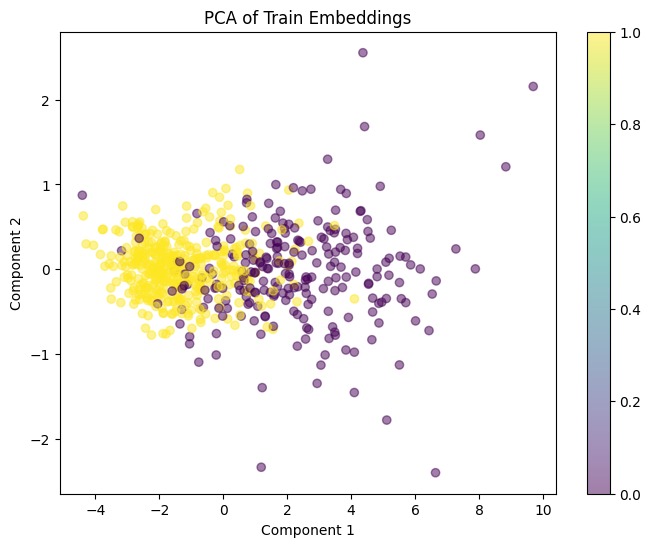

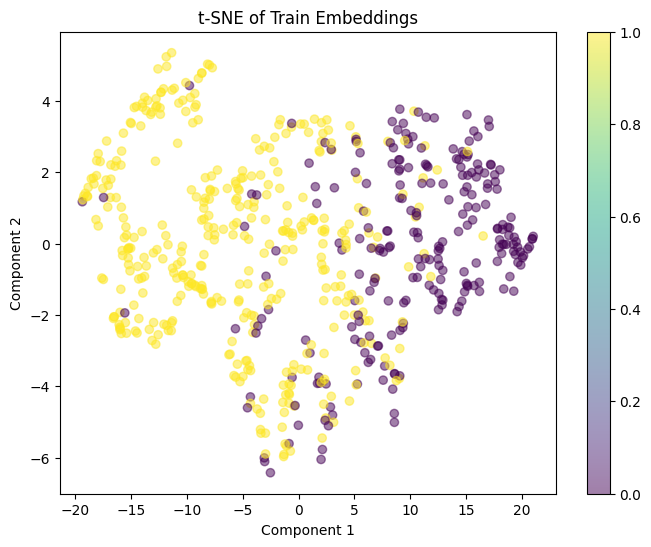

In [ ]:
# TODO: EXAMINE LATENT SPACE
test_embeddings, test_labels = extract_embeddings(test_loader_pneumonia, model_pneumonia_transfer_frozen)

# Plot embeddings
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()

# TODO: Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(test_embeddings_flat)

# TODO: Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(test_embeddings_flat)

# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu(), 'PCA of Train Embeddings')

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu(), 't-SNE of Train Embeddings')


### Transfer learning - Trainable

In [ ]:
model_pneumonia_transfer_trainable = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)

# TODO: Transfer the weights from the chest model to the pneumonia model
model_pneumonia_transfer_trainable.load_state_dict(model_chest.state_dict())

# Initialize the optimizer
optimizer_pneumonia_transfer_trainable = optim.SGD(model_pneumonia_transfer_trainable.parameters(), lr=lr, momentum=0.9)

In [ ]:
# train
model_pneumonia_transfer_trainable = train(model_pneumonia_transfer_trainable, train_loader_pneumonia, optimizer_pneumonia_transfer_trainable, convert_to_binary=False, epochs=10, device=device)

100%|██████████| 74/74 [00:01<00:00, 69.73it/s]


Epoch: 1	Loss: 0.1972


100%|██████████| 74/74 [00:01<00:00, 51.56it/s]


Epoch: 2	Loss: 0.0990


100%|██████████| 74/74 [00:01<00:00, 51.07it/s]


Epoch: 3	Loss: 0.0700


100%|██████████| 74/74 [00:01<00:00, 41.21it/s]


Epoch: 4	Loss: 0.0518


100%|██████████| 74/74 [00:01<00:00, 41.54it/s]


Epoch: 5	Loss: 0.0417


100%|██████████| 74/74 [00:01<00:00, 69.01it/s]


Epoch: 6	Loss: 0.0316


100%|██████████| 74/74 [00:01<00:00, 67.44it/s]


Epoch: 7	Loss: 0.0271


100%|██████████| 74/74 [00:01<00:00, 66.53it/s]


Epoch: 8	Loss: 0.0210


100%|██████████| 74/74 [00:01<00:00, 67.58it/s]


Epoch: 9	Loss: 0.0180


100%|██████████| 74/74 [00:01<00:00, 67.56it/s]

Epoch: 10	Loss: 0.0134


In [ ]:
# evaluation
print('==> Evaluating ...')
print('train')
test(model_pneumonia_transfer_trainable, train_loader_pneumonia, device, convert_to_binary=False)
print('test')
test(model_pneumonia_transfer_trainable, test_loader_pneumonia, device, convert_to_binary=False)

==> Evaluating ...
train
acc: 0.999
test
acc: 0.838


(tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
         1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
         1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
         1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
         1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
         0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
         1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
         1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
         0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
         0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
         1, 1, 0, 1, 1, 1, 1

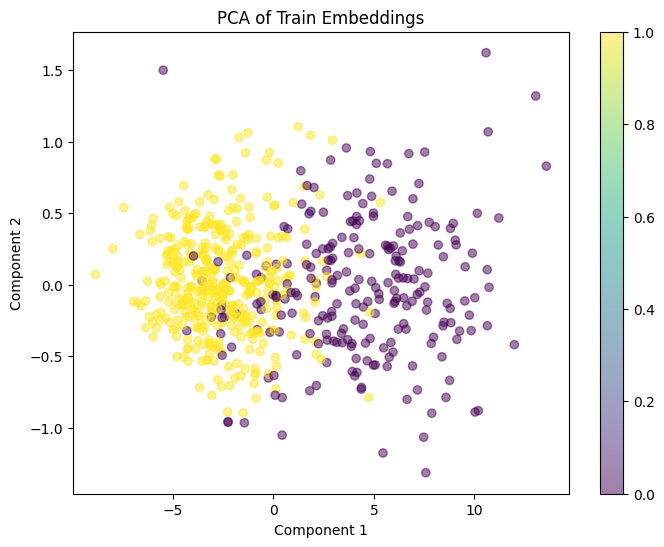

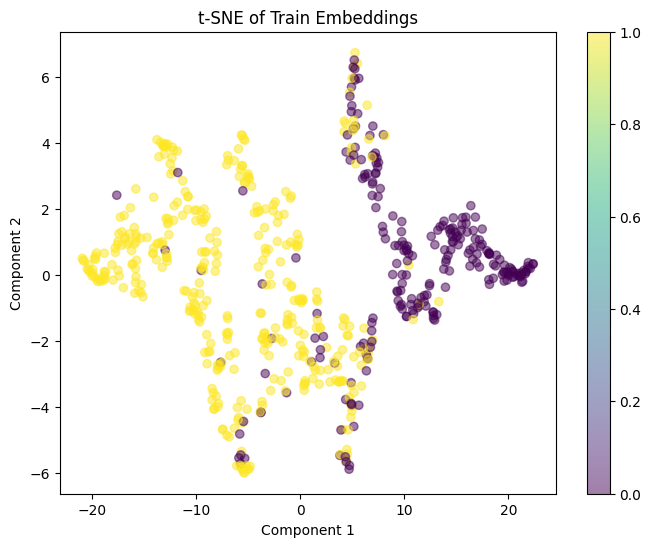

In [ ]:
# TODO: EXAMINE LATENT SPACE
test_embeddings, test_labels = extract_embeddings(test_loader_pneumonia, model_pneumonia_transfer_trainable)

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()

# TODO: Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(test_embeddings_flat)

# TODO: Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(test_embeddings_flat)

# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu(), 'PCA of Train Embeddings')

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu(), 't-SNE of Train Embeddings')


### BONUS: Transfer learning

In [ ]:
model_pneumonia_transfer_trainable = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)

# TODO: Transfer the weights from the chest model to the pneumonia model
model_pneumonia_transfer_trainable.load_state_dict(model_chest.state_dict())

# Freeze all layers except the FC layers
for param in model_pneumonia_transfer_frozen.parameters():
    param.requires_grad = False

# Unfreeze the FC layers
for param in model_pneumonia_transfer_frozen.fc.parameters():
    param.requires_grad = True

# Initialize the optimizer
optimizer_pneumonia_transfer_trainable = optim.SGD(model_pneumonia_transfer_trainable.parameters(), lr=lr, momentum=0.9)

# train
model_pneumonia_transfer_trainable = train(model_pneumonia_transfer_trainable, train_loader_pneumonia, optimizer_pneumonia_transfer_trainable, convert_to_binary=False, epochs=10, device=device)

# Unfreeze all layers
for param in model_pneumonia_transfer_trainable.parameters():
    param.requires_grad = True

# train
optimizer_pneumonia_transfer_trainable = optim.SGD(model_pneumonia_transfer_trainable.parameters(), lr=1e-5, momentum=0.9)
model_pneumonia_transfer_trainable = train(model_pneumonia_transfer_trainable, train_loader_pneumonia, optimizer_pneumonia_transfer_trainable, convert_to_binary=False, epochs=10, device=device)

100%|██████████| 74/74 [00:01<00:00, 47.66it/s]


Epoch: 1	Loss: 0.1988


100%|██████████| 74/74 [00:01<00:00, 66.56it/s]


Epoch: 2	Loss: 0.0949


100%|██████████| 74/74 [00:01<00:00, 66.67it/s]


Epoch: 3	Loss: 0.0704


100%|██████████| 74/74 [00:01<00:00, 67.59it/s]


Epoch: 4	Loss: 0.0528


100%|██████████| 74/74 [00:01<00:00, 67.61it/s]


Epoch: 5	Loss: 0.0424


100%|██████████| 74/74 [00:01<00:00, 54.09it/s]


Epoch: 6	Loss: 0.0362


100%|██████████| 74/74 [00:01<00:00, 48.40it/s]


Epoch: 7	Loss: 0.0288


100%|██████████| 74/74 [00:02<00:00, 30.58it/s]


Epoch: 8	Loss: 0.0227


100%|██████████| 74/74 [00:01<00:00, 56.92it/s]


Epoch: 9	Loss: 0.0174


100%|██████████| 74/74 [00:01<00:00, 64.88it/s]


Epoch: 10	Loss: 0.0145


100%|██████████| 74/74 [00:01<00:00, 66.90it/s]


Epoch: 1	Loss: 0.0118


100%|██████████| 74/74 [00:01<00:00, 66.68it/s]


Epoch: 2	Loss: 0.0125


100%|██████████| 74/74 [00:01<00:00, 68.01it/s]


Epoch: 3	Loss: 0.0116


100%|██████████| 74/74 [00:01<00:00, 66.19it/s]


Epoch: 4	Loss: 0.0116


100%|██████████| 74/74 [00:01<00:00, 67.49it/s]


Epoch: 5	Loss: 0.0114


100%|██████████| 74/74 [00:01<00:00, 63.00it/s]


Epoch: 6	Loss: 0.0118


100%|██████████| 74/74 [00:01<00:00, 48.01it/s]


Epoch: 7	Loss: 0.0118


100%|██████████| 74/74 [00:01<00:00, 48.72it/s]


Epoch: 8	Loss: 0.0113


100%|██████████| 74/74 [00:01<00:00, 56.63it/s]


Epoch: 9	Loss: 0.0114


100%|██████████| 74/74 [00:01<00:00, 66.38it/s]

Epoch: 10	Loss: 0.0103


In [ ]:
# evaluation
print('==> Evaluating ...')
print('train')
test(model_pneumonia_transfer_trainable, train_loader_pneumonia, device, convert_to_binary=False)
print('test')
test(model_pneumonia_transfer_trainable, test_loader_pneumonia, device, convert_to_binary=False)

==> Evaluating ...
train
acc: 1.000
test
acc: 0.841


(tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
         1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
         1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
         1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
         1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
         0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
         1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
         1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
         0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
         0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
         1, 1, 0, 1, 1, 1, 1

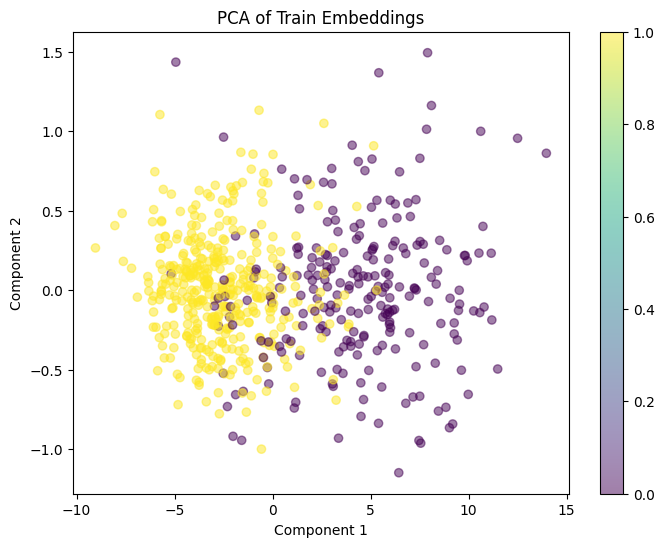

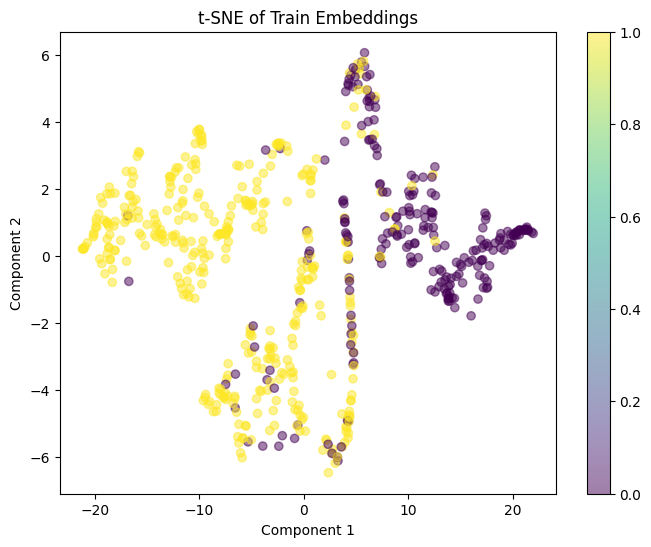

In [ ]:
# TODO: EXAMINE LATENT SPACE
test_embeddings, test_labels = extract_embeddings(test_loader_pneumonia, model_pneumonia_transfer_trainable)

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()

# TODO: Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(test_embeddings_flat)

# TODO: Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(test_embeddings_flat)

# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu(), 'PCA of Train Embeddings')

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu(), 't-SNE of Train Embeddings')
